### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

### Setup

In [2]:
train = pd.read_csv("../data/raw/train.csv")
stores = pd.read_csv("../data/raw/stores.csv")
features = pd.read_csv("../data/raw/features.csv")
test = pd.read_csv("../data/raw/test.csv")

In [3]:
# Ensure Date is a datetime everywhere
for df in [train, features, test]:
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])

print(train.shape, stores.shape, features.shape, test.shape)

(421570, 5) (45, 3) (8190, 12) (115064, 4)


### Handle negative weekly sales

I remove any negative sales values, since weekly sales cannot be negative in reality. 

In [4]:
# Keep a copy of negative sales for transparency
negative_sales = train[train["Weekly_Sales"] < 0].copy()
print("Negative sales records:", len(negative_sales))

# Save them (so the cleaning is reproducible)
from pathlib import Path
Path("../data/processed").mkdir(parents=True, exist_ok=True)
negative_sales.to_csv("../data/processed/negative_sales_records.csv", index=False)

# Clean training data
train_clean = train[train["Weekly_Sales"] >= 0].copy()
print("Train after filtering negatives:", train_clean.shape)

Negative sales records: 1285
Train after filtering negatives: (420285, 5)


### Merge train with features and stores

I merge `train` + `features` (Store/Date) and then add `stores` attributes (Type/Size) to obtain a single, analysis-ready table.

In [5]:
print("train:", train.columns.tolist())
print("stores:", stores.columns.tolist())
print("features:", features.columns.tolist())

train: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
stores: ['Store', 'Type', 'Size']
features: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']


In [6]:
df = (train_clean
    .merge(features, on=["Store", "Date"], how="left", suffixes=("", "_features"))
    .merge(stores, on=["Store"], how="left"))
print("Merged shape:", df.shape)
print(df.head())

Merged shape: (420285, 17)
   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  IsHoliday_features Type    Size  
0         8.10

### Date features (for plots & later modeling)

In [7]:
df["Year"]   = df["Date"].dt.year
df["Month"]  = df["Date"].dt.month
df["Quarter"]= df["Date"].dt.quarter
# ISO week number 
df["ISO_Week"] = df["Date"].dt.isocalendar().week.astype(int)

In [8]:
print(df.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...  MarkDown5         CPI  Unemployment  \
0        NaN        NaN        NaN  ...        NaN  211.096358         8.106   
1        NaN        NaN        NaN  ...        NaN  211.242170         8.106   
2        NaN        NaN        NaN  ...        NaN  211.289143         8.106   
3        NaN        NaN        NaN  ...        NaN  211.319643         8.106   
4        NaN        NaN        NaN  ...        NaN  211.350143         8.106   

   IsHoliday_features  Type    Size  Year  M

### Distribution of sales (original & log)

### Log Transformation of Weekly Sales

The distribution of `Weekly_Sales` is **right-skewed**, meaning that most values are small while a few are very large.  
This can make modeling more difficult, as many machine learning algorithms assume a more symmetric distribution.  

To reduce skewness and stabilize variance, I apply a **log transformation** using `log1p`

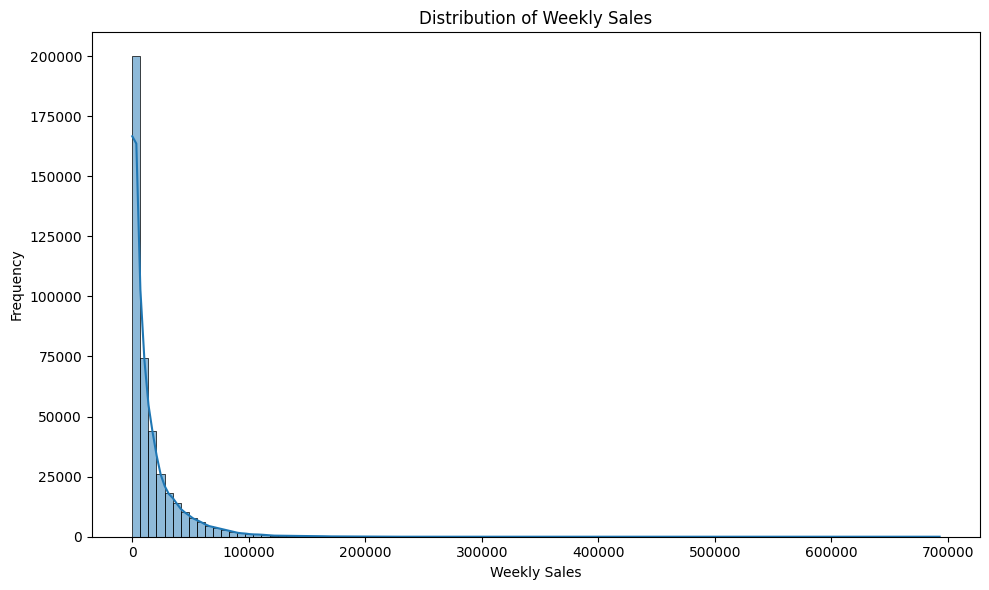

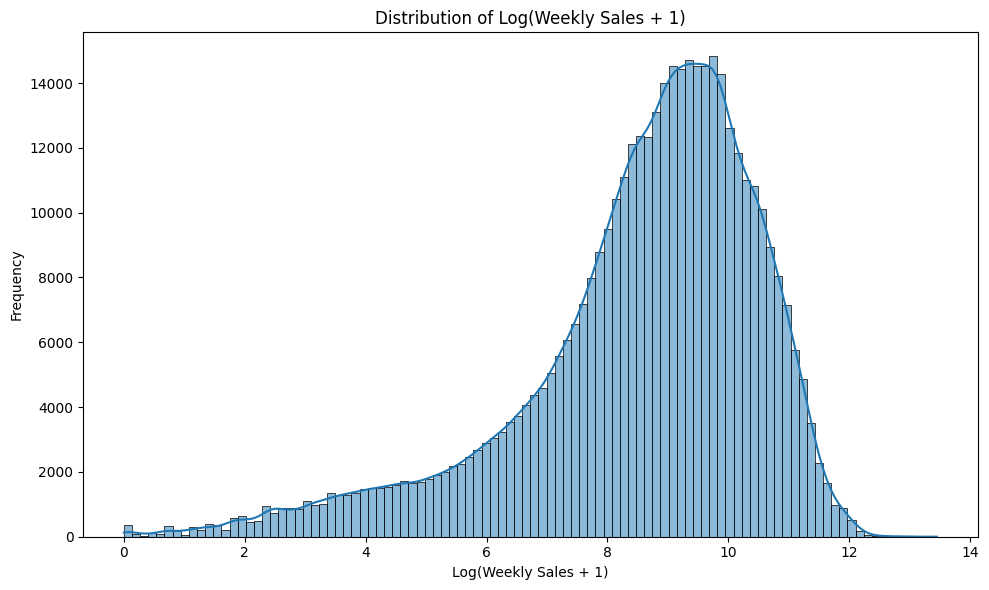

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(df["Weekly_Sales"], bins=100, kde=True)
plt.title("Distribution of Weekly Sales")
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.tight_layout() 
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(np.log1p(df["Weekly_Sales"]), bins=100, kde=True)
plt.title("Distribution of Log(Weekly Sales + 1)")
plt.xlabel("Log(Weekly Sales + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Total weekly sales over time

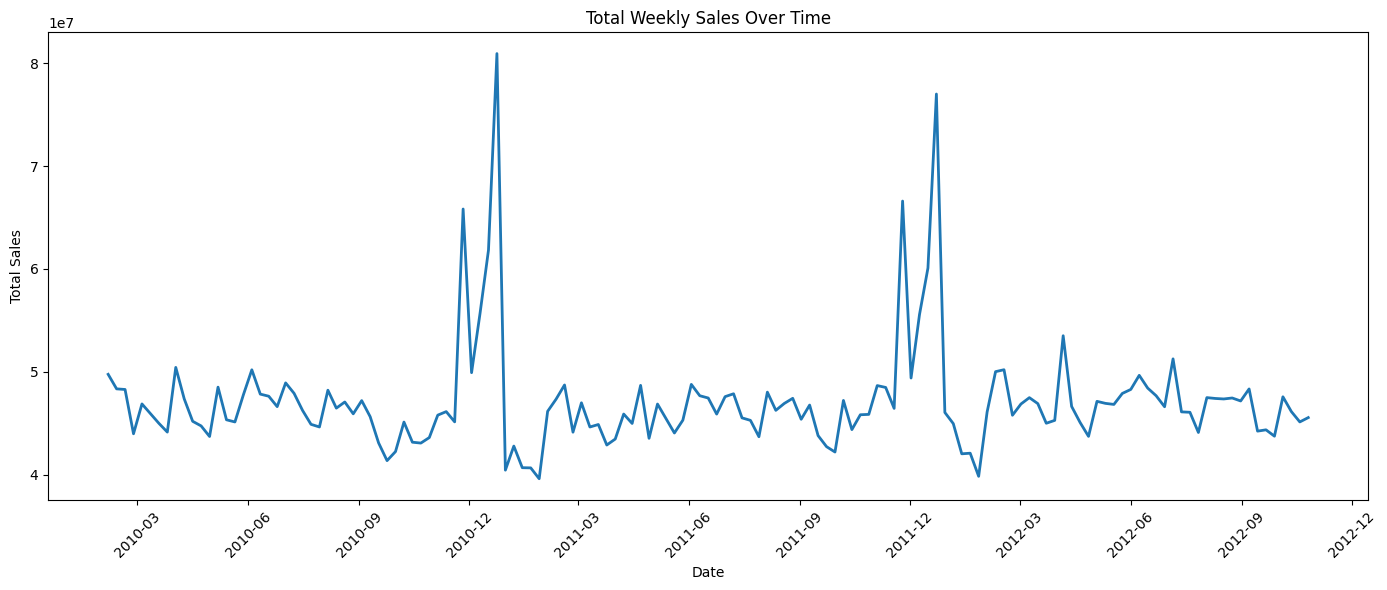

In [10]:
weekly_total = df.groupby("Date", as_index=False)["Weekly_Sales"].sum()

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(weekly_total["Date"], weekly_total["Weekly_Sales"], linewidth=2)
ax.set_title("Total Weekly Sales Over Time")
ax.set_xlabel("Date") 
ax.set_ylabel("Total Sales")

# Show one tick every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Seasonality:** Even with roughly two years of data, I observe clear holiday season effects: sales spike in **December** in both years, while the rest of the year remains comparatively stable.

### Holiday impact

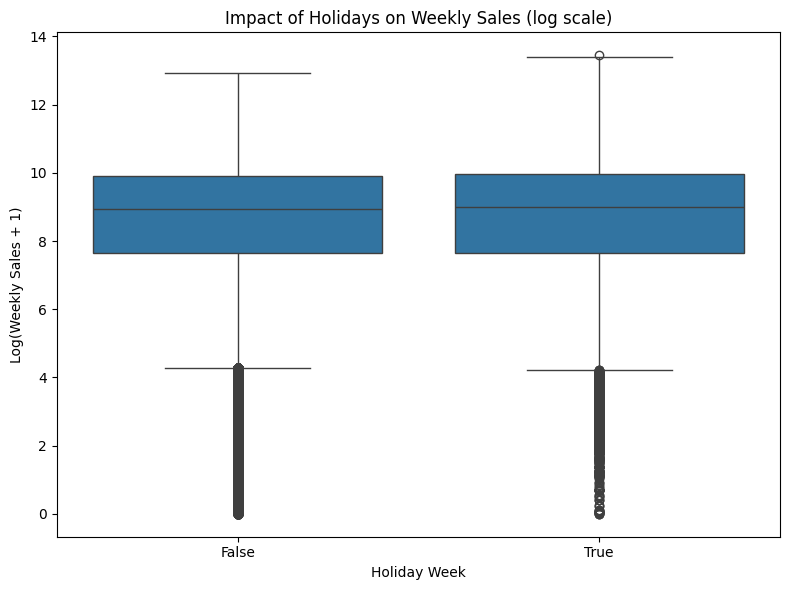

In [11]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="IsHoliday", y=np.log1p(df["Weekly_Sales"]))
plt.title("Impact of Holidays on Weekly Sales (log scale)")
plt.xlabel("Holiday Week")
plt.ylabel("Log(Weekly Sales + 1)")
plt.tight_layout()
plt.show()

### Store characteristics

  Type  Weekly_Sales
0    A  20145.109276
1    B  12288.133746
2    C   9547.430645


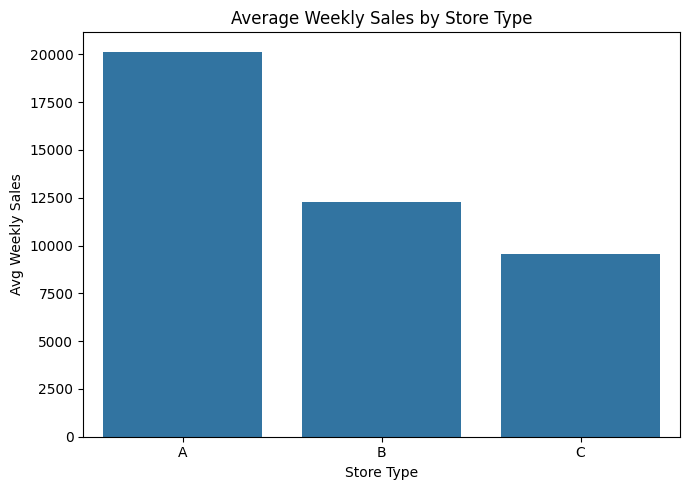

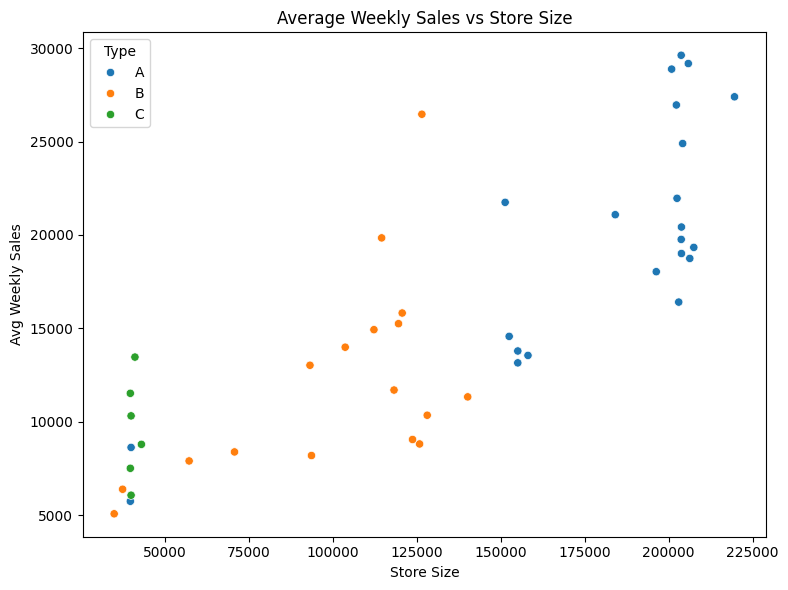

In [12]:
# Average sales by store type
type_avg = (df.groupby("Type", as_index=False)["Weekly_Sales"]
              .mean().sort_values("Weekly_Sales", ascending=False))
print(type_avg)

plt.figure(figsize=(7,5))
sns.barplot(data=type_avg, x="Type", y="Weekly_Sales")
plt.title("Average Weekly Sales by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Avg Weekly Sales")
plt.tight_layout()
plt.show()

# Relationship with store size
store_agg = df.groupby("Store", as_index=False).agg({
    "Weekly_Sales": "mean",
    "Size": "mean",
    "Type": "first"   
})
plt.figure(figsize=(8,6))
sns.scatterplot(data=store_agg, x="Size", y="Weekly_Sales", hue="Type")
plt.title("Average Weekly Sales vs Store Size")
plt.xlabel("Store Size")
plt.ylabel("Avg Weekly Sales")
plt.tight_layout()
plt.show()

### Correlations with exogenous variables

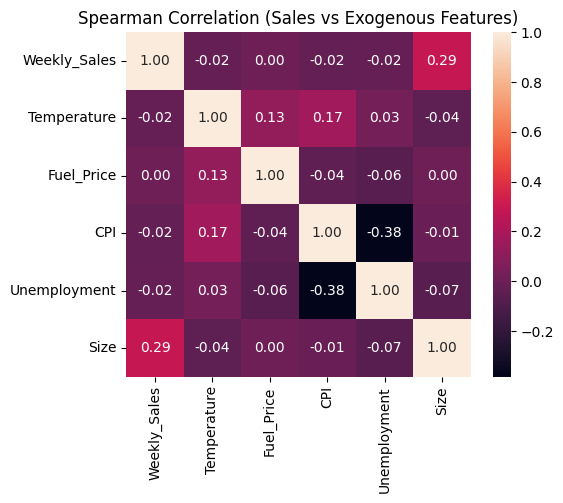

In [13]:
num_cols = ["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment","Size"]
corr = df[num_cols].corr(method="spearman")  # robust to skew
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Spearman Correlation (Sales vs Exogenous Features)")
plt.tight_layout()
plt.show()

### Save a cleaned /merged version for modeling

In [14]:
cols_to_keep = [
    "Store","Dept","Date","Year","Month","Quarter","ISO_Week",
    "Weekly_Sales","IsHoliday","Type","Size","Temperature","Fuel_Price","CPI","Unemployment"
]
df_out = df[cols_to_keep].copy()
df_out.to_csv("../data/processed/train_merged_clean.csv", index=False)
print("Saved:", df_out.shape, "-> ../data/processed/train_merged_clean.csv")


Saved: (420285, 15) -> ../data/processed/train_merged_clean.csv


### EDA Takeaways
- Strong **seasonality** with pronounced December peaks.
- **Holiday weeks** show higher sales distributions.
- Store **Type/Size** correlate with average sales levels.
- Exogenous features (Temperature, CPI, Unemployment, Fuel_Price) show modest correlations and may help forecasting when engineered carefully.